<a href="https://colab.research.google.com/github/vilcagamarracf/Inv_arroz_METRIC/blob/main/files/Inv_Arroz_METRIC_Pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pruebas (Google Colab)

#### Inicio

##### Credenciales

In [1]:
# # Ingresa tus credenciales de Google Earth Engine para comenzar
# import ee
# ee.Authenticate()

# # Inicio
# ee.Initialize()

# # Mensaje de login
# print('\nYa estás logeado.')
# print('GEE Version:', ee.__version__)

In [2]:
#@markdown *Credenciales Google Earth Engine: Forma rápida*
import os 
credential = '{"refresh_token":"1//09lhqedCNpNDsCgYIARAAGAkSNwF-L9IraEP8FyJma46WSiEHhOMsZqSoTPJsi3Lar0C4nZUwj2QCZ_i66-McVzy4NmMalQL17KM"}'
credential_file_path = os.path.expanduser("~/.config/earthengine/")
os.makedirs(credential_file_path,exist_ok=True)
with open(credential_file_path + 'credentials', 'w') as file:
    file.write(credential)
import ee
ee.Initialize()
print('Ya estás logeado.')
print('GEE Version:',ee.__version__)

Ya estás logeado.
GEE Version: 0.1.290


##### geemap

In [3]:
# Instalar geemap
%%capture
!pip install -U geemap # Nota: Con la actualización de ipyleaflet v0.15.0 se produjo un conflicto con geemap
# !pip install geemap==0.10.1

Documentación `geemap`
- [geemap - key features](https://geemap.org/notebooks/00_geemap_key_features/)

In [4]:
import geemap
# import geemap.eefolium as geemap
Map = geemap.Map(basemap='HYBRID', center=(-9.125, -74.396), zoom=5) # basemap='HYBRID', 'OpenStreetMap.Mapnik' 
# Map

##### Funciones

In [5]:
# Mejorar visibilidad de tablas en Colab
%load_ext google.colab.data_table

# Para volver al estado original de las tablas
# %unload_ext google.colab.data_table

In [6]:
# Funciones usadas en Inv-Arroz-METRIC

import ee           
import geemap
import pandas as pd
from ipywidgets import interact, fixed

import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates # Modificar fechas por formato
date_format = mpl_dates.DateFormatter('%Y-%m')

In [7]:
# @markdown Función `generar_reporte(icol)`

def generar_reporte(icol):
  """Generar reportes para ee.ImageCollection 's
  
  A partir de un ee.ImageCollection devolver una tabla 
  con información de ID, Fechas (Año, Mes, Día, Día Juliano) y 
  propiedades como Ángulo Zenital y Porcentaje de Nubosidad.

  Argumentos:
  - icol : ee.ImageCollection
  Retorna:
  - pandas.Dataframe
  """
  ## Generando campos para la tabla
  ID_snippet_name = icol.getInfo()['id']

  # Lista con fechas (en milisegundos)
  lista_fechas = icol.aggregate_array('system:time_start').getInfo() # Fechas
  # Lista con ID's
  imgCol_ids = [f'{ID_snippet_name}/{i}' for i in icol.aggregate_array("system:index").getInfo()] # ID

  # Armando dataframe
  df = pd.DataFrame(lista_fechas, columns = ['millis'])

  df["ID GEE"] = imgCol_ids
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Fecha Precisa'] = pd.DatetimeIndex(df['Timestamp']) # Con hora
  # df['Fecha Corta'] = pd.DatetimeIndex(df['Timestamp']).date
  df['Año'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Mes'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Día'] = pd.DatetimeIndex(df['Timestamp']).day
  # df['Hora'] = pd.DatetimeIndex(df['Timestamp']).hour
  df['Día Juliano'] = pd.DatetimeIndex(df['Timestamp']).dayofyear

  # Agregando propiedades
  if ID_snippet_name == 'LANDSAT/LC08/C01/T1_SR':
    df['SOLAR_ZENITH_ANGLE'] = icol.aggregate_array('SOLAR_ZENITH_ANGLE').getInfo()
    df['CLOUD_COVER'] = icol.aggregate_array('CLOUD_COVER').getInfo()

  elif ID_snippet_name in ['LANDSAT/LT05/C02/T1_L2','LANDSAT/LC08/C02/T1_L2','LANDSAT/LE07/C02/T1_L2']:
    df['CLOUD_COVER'] = icol.aggregate_array('CLOUD_COVER').getInfo()
    df['SUN_ELEVATION'] = icol.aggregate_array('SUN_ELEVATION').getInfo()
    df['ZENITH ANGLE'] = 90. - df['SUN_ELEVATION']
    df['ZENITH ANGLE'] = df['ZENITH ANGLE'].round(decimals=7)
    df = df.drop(columns=['SUN_ELEVATION'])

  elif ID_snippet_name == 'COPERNICUS/S2_SR':
    df['MEAN_SOLAR_ZENITH_ANGLE'] = icol.aggregate_array('MEAN_SOLAR_ZENITH_ANGLE').getInfo()
    df['CLOUDY_PIXEL_PERCENTAGE'] = icol.aggregate_array('CLOUDY_PIXEL_PERCENTAGE').getInfo()
  
  df = df.drop(columns=['millis', 'Timestamp'])
  # df.to_csv('datos_2020_L8_SR.csv')
  
  return df

In [19]:
# @markdown Función `ver_imgs_mensual(mes, df, roi)`
def ver_imgs_mensual(mes, df, roi):
  """Visualizar imágenes a partir del reporte generado con la función generar_reporte
  
  Argumentos:
  - mes : lista de valores [1,2,3] del 1 al 12 que representen los meses
  - df : pandas.DataFrame con columna 'ID GEE' de ID's 
  - roi : ee.geometry o ee.FeatureCollection 
  Retorna:
  - ee.Image

  Usarse con interact
  """
  # Del dataframe obtenemos las imagenes de acuerdo al mes que queramos
  lista_imagenes = df[df['Mes'] == mes]['ID GEE'].tolist()
  snippet_name = lista_imagenes[0]

  # Parametros de visualización RGB
  bands = ['B4', 'B3', 'B2']
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands}# 'gamma':1.4
  
  # Visualización
  # import geemap.eefolium as geemap
  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik', 
  Map.centerObject(roi, 11)  # Map.setCenter(-79.809, -6.746, 9)

  if 'COPERNICUS/S2_SR' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0001)                 
      # image = maskS2clouds(ee.Image(i)).multiply(0.0001)               
      Map.addLayer(image, vis_rgb, f'Imagen {i}')

  elif 'LANDSAT/LC08/C01/T1_SR' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0001)
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  elif 'LANDSAT/LC08/C02/T1_L2' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0000275).add(-0.2)
      bands = ['SR_B4', 'SR_B3', 'SR_B2']
      vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands} 
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')
    
  elif 'LANDSAT/LE07/C02/T1_L2' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0000275).add(-0.2)
      bands = ['SR_B3', 'SR_B2', 'SR_B1']
      vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands}
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  elif 'LANDSAT/LT05/C02/T1_L2' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0000275).add(-0.2)
      bands = ['SR_B3', 'SR_B2', 'SR_B1']
      vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands}
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  Map.addLayer(roi, {'color':'00FF00'}, 'ROI')
  return Map

In [9]:
# @markdown Función `maskS2clouds(image)` para enmascarar nubes en imágenes Sentinel-2

## Operadores de bit a bit
# Operador bit a bit desplazamiento a la izquierda <<
# Little indian (los bits se cuentan de izq a derecha) y Big indian (los bits se cuentan de derecha a izq)
def maskS2clouds(image):
  qa = image.select('QA60')
  opaque_cloud = 1 << 10
  cirrus_cloud = 1 << 11
  mask = (
      qa.bitwiseAnd(opaque_cloud).eq(0)
      .And(qa.bitwiseAnd(cirrus_cloud).eq(0))
  )
  clean_image = (
      image.updateMask(mask)
      .divide(10000)
      .copyProperties(image, ["system:time_start"])
  )
  return clean_image

## Visualizaciones

### Distrito de Chongoyape

Assets personales con datos vectoriales provistos por el Instituto Geográfico Nacional (IGN) de manera [pública](https://www.idep.gob.pe/#visor):
- Departamentos: `'users/CesarVilca/departamentos'`
- Provincias: `'users/CesarVilca/provincias'`
- Distritos: `'users/CesarVilca/distritos'`

In [12]:
# Ejemplo de filtrado

# Assets
asset_departamentos = ee.FeatureCollection('users/CesarVilca/departamentos')
asset_provincias = ee.FeatureCollection('users/CesarVilca/provincias')
asset_distritos = ee.FeatureCollection('users/CesarVilca/distritos')

# Filtrado
lambayeque = asset_departamentos.filterMetadata('DEPARTAMEN','equals','LAMBAYEQUE')
chiclayo = asset_provincias.filterMetadata('PROVINCIA','equals','CHICLAYO')
chongoyape = asset_distritos.filterMetadata('DISTRITO','equals','CHONGOYAPE')

# Punto
chongoyape_punto = ee.Geometry.Point([-79.389, -6.639])
chongoyape_bound = chongoyape.geometry().bounds() # CAJA

# Zona de evaluación
parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape")

In [15]:
# @markdown Visualización con `geemap`: Distrito de Chongoyape

# Visualización
LambayequeDraw = lambayeque.draw(color = "D8EED0", strokeWidth = 1, pointRadius = 2) 
ChiclayoDraw = chiclayo.draw(color = "00FF00", strokeWidth = 1, pointRadius = 2) 
ChongoyapeDraw = chongoyape.draw(color = "00FFFF", strokeWidth = 1, pointRadius = 2) 
parcelasDraw = parcelas_chongoyape.draw(color = "0000FF", strokeWidth = 1, pointRadius = 2) 

Map = geemap.Map(basemap='HYBRID', layer_ctrl=True) # OpenStreetMap.Mapnik
Map.centerObject(parcelas_chongoyape, 11) # Map.setCenter(lon, lat, zoom)
Map.addLayer(LambayequeDraw, {}, name = 'Lambayeque')
Map.addLayer(ChiclayoDraw, {}, name = 'Chiclayo')
Map.addLayer(chongoyape_bound, {}, name = 'chongoyape_bound')
Map.addLayer(ChongoyapeDraw, {}, name = 'Chongoyape')
Map.addLayer(parcelasDraw, {}, name = 'Parcelas Chongoyape')

Map

Map(center=[-6.612570768066261, -79.39809118558777], controls=(WidgetControl(options=['position', 'transparent…

### Landsat

#### Landsat

###### USGS Landsat 8 Surface Reflectance Tier 1 [deprecated] - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR)

In [16]:
# Filtrado Landsat 8
snippet_name = "LANDSAT/LC08/C01/T1_SR"
path = 10
row = 65
year = 2021
roi = chongoyape_punto

icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
    .filterBounds(roi)
)

reporteL8_C1 = generar_reporte(icol_sr)
reporteL8_C1

ID GEE  ... CLOUD_COVER
0   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210102  ...       40.61
1   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210203  ...        2.62
2   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210307  ...       35.30
3   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210323  ...       11.67
4   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210408  ...       48.31
5   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210424  ...       28.75
6   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210510  ...        9.94
7   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210526  ...       88.94
8   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210611  ...       97.44
9   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210627  ...       88.26
10  LANDSAT/LC08/C01/T1_SR/LC08_010065_20210713  ...       82.47
11  LANDSAT/LC08/C01/T1_SR/LC08_010065_20210729  ...       96.47
12  LANDSAT/LC08/C01/T1_SR/LC08_010065_20210814  ...       61.22
13  LANDSAT/LC08/C01/T1_SR/LC08_010065_20210830  ...       84.47
14  LANDSAT/LC08/C01/T1_SR/LC08_010065_20210915  ...       74.76
15  LANDSAT/LC08/C01/T1_SR/LC08_010065_20211001  ...       72.18
16  LANDSAT/LC08/C01/T1_SR/LC08_010065_20211017  ...       71.68

[17 rows x 8 columns]

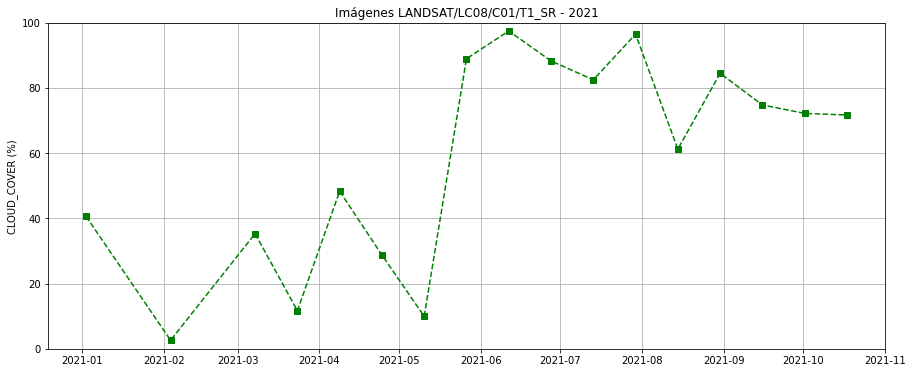

In [17]:
plt.figure(figsize=(15,6))
plt.plot(reporteL8_C1['Fecha Precisa'], reporteL8_C1['CLOUD_COVER'], 'gs--')
plt.title(f'Imágenes {snippet_name} - {year}'), plt.ylabel('CLOUD_COVER (%)'), plt.ylim(0,100)
plt.grid()

La última imagen data del 17 de Octubre, a partir de esa fecha ya no registra más imágenes en la colección para la zona de evaluación. 

In [20]:
mes = reporteL8_C1['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteL8_C1), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output())…

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: No hay imágenes


###### USGS Landsat 8 Level 2, Collection 2, Tier 1 - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2)

In [21]:
snippet_name = "LANDSAT/LC08/C02/T1_L2"
path = 10
row = 65
year = 2021

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_C2 = generar_reporte(icol_sr)
reporteL8_C2

ID GEE  ... ZENITH ANGLE
0   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210102  ...    31.894129
1   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210203  ...    31.967307
2   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210307  ...    30.574302
3   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210323  ...    30.729299
4   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210408  ...    31.944175
5   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210424  ...    34.098745
6   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210510  ...    36.695052
7   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210526  ...    39.111781
8   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210611  ...    40.849695
9   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210627  ...    41.507404
10  LANDSAT/LC08/C02/T1_L2/LC08_010065_20210713  ...    40.875147
11  LANDSAT/LC08/C02/T1_L2/LC08_010065_20210729  ...    38.937776
12  LANDSAT/LC08/C02/T1_L2/LC08_010065_20210814  ...    35.903923
13  LANDSAT/LC08/C02/T1_L2/LC08_010065_20210830  ...    32.179696
14  LANDSAT/LC08/C02/T1_L2/LC08_010065_20210915  ...    28.408939
15  LANDSAT/LC08/C02/T1_L2/LC08_010065_20211001  ...    25.412761
16  LANDSAT/LC08/C02/T1_L2/LC08_010065_20211017  ...    24.016849
17  LANDSAT/LC08/C02/T1_L2/LC08_010065_20211102  ...    24.514764
18  LANDSAT/LC08/C02/T1_L2/LC08_010065_20211118  ...    26.406123

[19 rows x 8 columns]

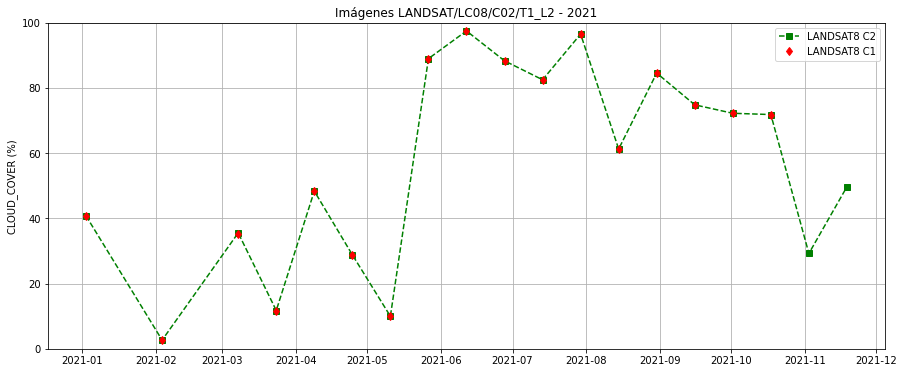

In [22]:
plt.figure(figsize=(15,6))
plt.plot(reporteL8_C2['Fecha Precisa'], reporteL8_C2['CLOUD_COVER'], 'gs--', label='LANDSAT8 C2') 
plt.plot(reporteL8_C1['Fecha Precisa'], reporteL8_C1['CLOUD_COVER'], 'rd', label='LANDSAT8 C1')
plt.title(f'Imágenes {snippet_name} - {year}'), plt.ylabel('CLOUD_COVER (%)'), plt.ylim(0,100)
plt.grid(), plt.legend();

In [24]:
mes = reporteL8_C2['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteL8_C2), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=1), Outpu…

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: 2 y 18


###### USGS Landsat 7 Level 2, Collection 2, Tier 1 - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C02_T1_L2)

In [25]:
snippet_name = 'LANDSAT/LE07/C02/T1_L2'
path = 10
row = 65
year = 2021

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL7_C2 = generar_reporte(icol_sr)
reporteL7_C2

ID GEE  ... ZENITH ANGLE
0   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210110  ...    41.576951
1   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210126  ...    42.291609
2   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210211  ...    42.370742
3   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210227  ...    42.155174
4   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210315  ...    42.093005
5   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210331  ...    42.565217
6   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210416  ...    43.780423
7   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210502  ...    45.623796
8   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210603  ...    49.796973
9   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210619  ...    51.241992
10  LANDSAT/LE07/C02/T1_L2/LE07_010065_20210705  ...    51.781028
11  LANDSAT/LE07/C02/T1_L2/LE07_010065_20210721  ...    51.262064
12  LANDSAT/LE07/C02/T1_L2/LE07_010065_20210806  ...    49.715637
13  LANDSAT/LE07/C02/T1_L2/LE07_010065_20210822  ...    47.393137
14  LANDSAT/LE07/C02/T1_L2/LE07_010065_20210907  ...    44.714463
15  LANDSAT/LE07/C02/T1_L2/LE07_010065_20211009  ...    40.590831
16  LANDSAT/LE07/C02/T1_L2/LE07_010065_20211025  ...    40.167843
17  LANDSAT/LE07/C02/T1_L2/LE07_010065_20211110  ...    41.045713

[18 rows x 8 columns]

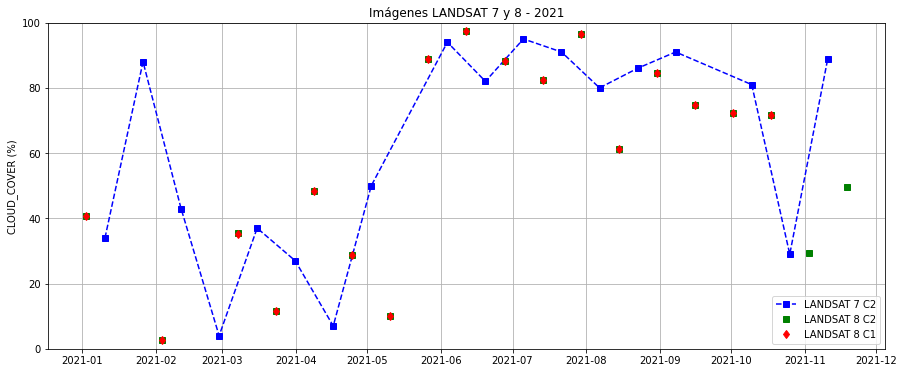

In [26]:
plt.figure(figsize=(15,6))
plt.plot(reporteL7_C2['Fecha Precisa'], reporteL7_C2['CLOUD_COVER'], 'bs--', label='LANDSAT 7 C2') 
plt.plot(reporteL8_C2['Fecha Precisa'], reporteL8_C2['CLOUD_COVER'], 'gs', label='LANDSAT 8 C2') 
plt.plot(reporteL8_C1['Fecha Precisa'], reporteL8_C1['CLOUD_COVER'], 'rd', label='LANDSAT 8 C1')
plt.title(f'Imágenes LANDSAT 7 y 8 - {year}'), plt.ylabel('CLOUD_COVER (%)'), plt.ylim(0,100)
plt.grid(), plt.legend();

In [28]:
mes = reporteL7_C2['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteL7_C2), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=1), Outpu…

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: 2 y 18


###### USGS Landsat 5 Level 2, Collection 2, Tier 1 - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LT05_C02_T1_L2)

Datos disponibles desde `1984-01-01` - `2012-05-05` lo que conlleva a máximo 4 imágenes en el año 2008.

In [40]:
snippet_name = 'LANDSAT/LT05/C02/T1_L2'
path = 10
row = 65
year = 2008

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL5_C2 = generar_reporte(icol_sr)
reporteL5_C2

ID GEE  ... ZENITH ANGLE
0  LANDSAT/LT05/C02/T1_L2/LT05_010065_20080404  ...    33.887959
1  LANDSAT/LT05/C02/T1_L2/LT05_010065_20080420  ...    35.686489
2  LANDSAT/LT05/C02/T1_L2/LT05_010065_20080506  ...    38.092512
3  LANDSAT/LT05/C02/T1_L2/LT05_010065_20080709  ...    43.422773

[4 rows x 8 columns]

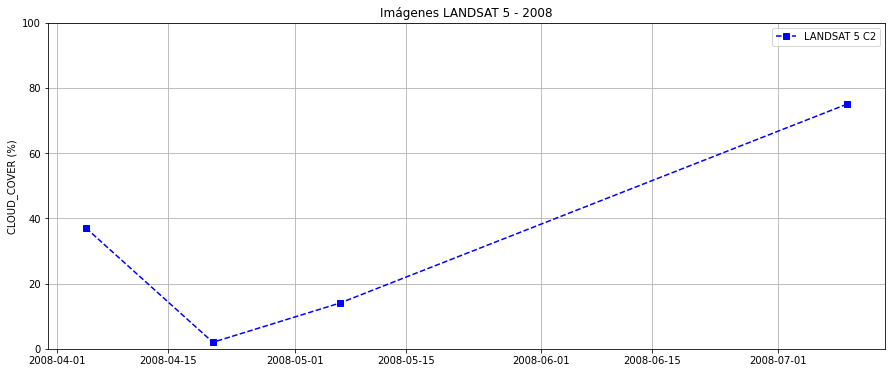

In [32]:
plt.figure(figsize=(15,6))
plt.plot(reporteL5_C2['Fecha Precisa'], reporteL5_C2['CLOUD_COVER'], 'bs--', label='LANDSAT 5 C2') 
plt.title(f'Imágenes LANDSAT 5 - {year}'), plt.ylabel('CLOUD_COVER (%)'), plt.ylim(0,100)
plt.grid(), plt.legend();

In [34]:
mes = reporteL5_C2['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteL5_C2), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='mes', options=(4, 5, 7), value=4), Output()), _dom_classes=('widge…

### Sentinel-2

In [41]:
# Filtrado Sentinel-2
snippet_name = 'COPERNICUS/S2_SR'
year = 2021
roi = chongoyape_punto

icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterBounds(roi)
)

reporteS2 = generar_reporte(icol_sr)
reporteS2

ID GEE  ... CLOUDY_PIXEL_PERCENTAGE
0   COPERNICUS/S2_SR/20210101T153619_20210101T1544...  ...               60.175373
1   COPERNICUS/S2_SR/20210106T153621_20210106T1540...  ...               96.552039
2   COPERNICUS/S2_SR/20210111T153619_20210111T1537...  ...               14.484162
3   COPERNICUS/S2_SR/20210116T153621_20210116T1540...  ...               92.622773
4   COPERNICUS/S2_SR/20210121T153619_20210121T1537...  ...               27.849255
..                                                ...  ...                     ...
66  COPERNICUS/S2_SR/20211122T153621_20211122T1540...  ...               31.135298
67  COPERNICUS/S2_SR/20211127T153619_20211127T1537...  ...               15.195945
68  COPERNICUS/S2_SR/20211202T153621_20211202T1540...  ...               73.484620
69  COPERNICUS/S2_SR/20211207T153619_20211207T1537...  ...               25.602575
70  COPERNICUS/S2_SR/20211212T153621_20211212T1541...  ...               15.497769

[71 rows x 8 columns]

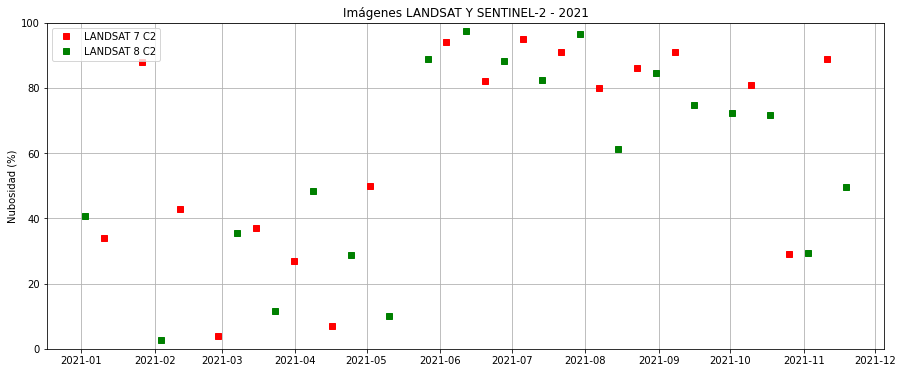

In [42]:
plt.figure(figsize=(15,6))
plt.plot(reporteL7_C2['Fecha Precisa'], reporteL7_C2['CLOUD_COVER'], 'rs', label='LANDSAT 7 C2') 
plt.plot(reporteL8_C2['Fecha Precisa'], reporteL8_C2['CLOUD_COVER'], 'gs', label='LANDSAT 8 C2') 
# plt.plot(reporteS2['Fecha Precisa'], reporteS2['CLOUDY_PIXEL_PERCENTAGE'], 'kd', label='SENTINEL-2')
plt.title(f'Imágenes LANDSAT Y SENTINEL-2 - {year}'), plt.ylabel('Nubosidad (%)'), plt.ylim(0,100)
plt.xticks([pd.Timestamp(f'{year}-{i}') for i in range(1,13)]), plt.gca().xaxis.set_major_formatter(date_format)
plt.grid(), plt.legend();

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 9, 14, 19, 24
- Setiembre: 3, 13, 18 (problema de corte), 28
- Octubre: 23 y 28
- Noviembre: 2, 7, 17, 22 y 27
- Diciembre: 2


In [43]:
mes = reporteS2['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteS2), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1), O…

### DEM SRTM

Comparación de datasets DEM: SRTM vs ALOS

- [NASA SRTM Digital Elevation 30m](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003)
- [ALOS DSM: Global 30m](https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_AW3D30_V2_2)

In [44]:
# Comparación entre dems: SRTM y ALOS (scale= 30m)

roi = chongoyape_bound

srtm = ee.Image("USGS/SRTMGL1_003").clip(roi)
alos = ee.Image("JAXA/ALOS/AW3D30/V2_2").select('AVE_DSM').clip(roi)

inferno_pal = ["#000004", "#560F6D", "#BB3654", "#F98C09", "#FCFFA4"]
vis_params = {'min':0, 'max':2000, 'palette': inferno_pal}

# Visualización
Map = geemap.Map() #basemap='HYBRID', layer_ctrl=True) # OpenStreetMap.Mapnik
# Map.setCenter(-70.61,-13.35, 10) #  Aquí se produce un fallo (comparar)
Map.centerObject(chongoyape_bound, 11)
Map.addLayer(srtm, vis_params, 'SRTM DEM')
Map.addLayer(alos, vis_params, 'ALOS DSM')
Map.addLayer(chongoyape, {}, 'Distrito Chongoyape')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

### Datos Meteorológicos

Estación Meteorológica Tinajones

In [ ]:
df_tinajones = pd.read_csv('Tinajones_datos_met_2021.csv', na_values='S/D')
df_tinajones.columns = [i.strip() for i in df_tinajones.columns.tolist()]
df_tinajones['FECHA'] = pd.to_datetime(df_tinajones['FECHA'] + ' ' + df_tinajones['HORA'], format='%d/%m/%Y %H:%M')
df_tinajones

FECHA  ... VELOCIDAD DEL VIENTO (m/s)
0    2021-01-01 00:00:00  ...                        2.9
1    2021-01-01 01:00:00  ...                        1.9
2    2021-01-01 02:00:00  ...                        1.3
3    2021-01-01 03:00:00  ...                        1.4
4    2021-01-01 04:00:00  ...                        1.0
...                  ...  ...                        ...
7993 2021-11-30 19:00:00  ...                        6.0
7994 2021-11-30 20:00:00  ...                        4.9
7995 2021-11-30 21:00:00  ...                        4.4
7996 2021-11-30 22:00:00  ...                        4.3
7997 2021-11-30 23:00:00  ...                        2.9

[7998 rows x 7 columns]

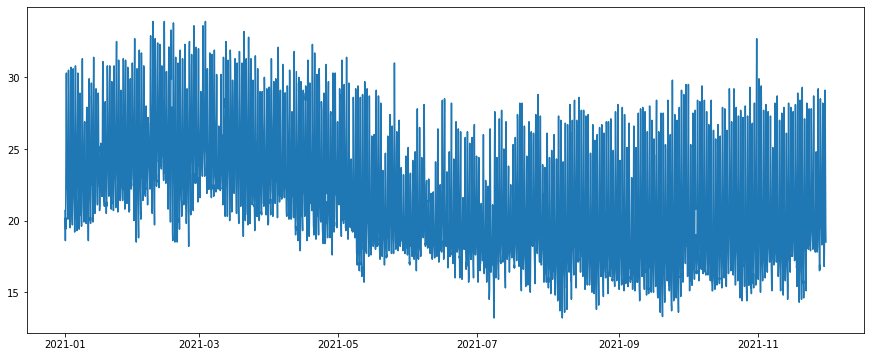

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_tinajones.FECHA, df_tinajones['TEMPERATURA (degree C)']);

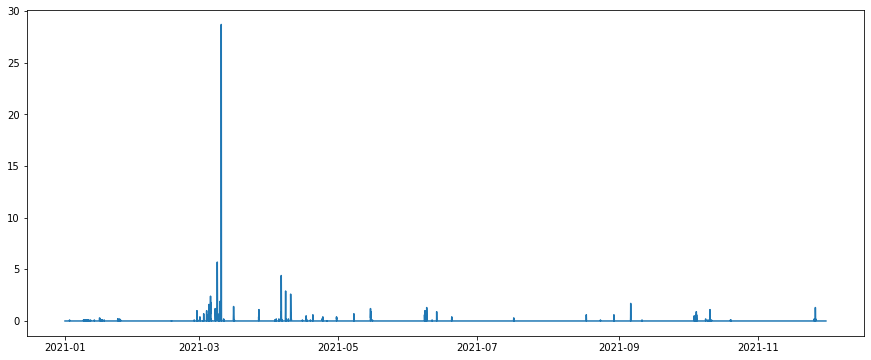

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_tinajones.FECHA, df_tinajones['PRECIPITACION (mm/hora)']);

### Indices de Vegetación

#### Previo
- Funciones
- Paletas de colores
- Visualizador de índices

In [45]:
# @markdown Indices de Vegetación:
# @markdown - NDVI
# @markdown   - Función `get_ndvi_S2(image)`
# @markdown   - Función `get_ndvi_L8(image)`
# @markdown   - Función `get_ndvi_L7(image)`
# @markdown - EVI
# @markdown   - Función `get_evi_S2(image)`

def get_ndvi_S2(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4').divide(10000),
       'nir' : image.select('B8').divide(10000)}).rename('NDVI')
  return image.addBands(ndvi)
  
def get_ndvi_L8(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('SR_B4').multiply(0.0000275).add(-0.2),
       'nir' : image.select('SR_B5').multiply(0.0000275).add(-0.2)}
       ).rename('NDVI')
  return image.addBands(ndvi)

def get_ndvi_L7(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('SR_B3').multiply(0.0000275).add(-0.2),
       'nir' : image.select('SR_B4').multiply(0.0000275).add(-0.2)}
       ).rename('NDVI')
  return image.addBands(ndvi)

# def ndvi_icol(image):
#   ndvi = image.normalizedDifference(['B8','B4']).rename('ndvi')
#   return image.addBands([ndvi])


def get_evi_S2(image):
  """
  https://developers.google.com/earth-engine/guides/image_math#expressions
  """
  evi = image.expression(
      '2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)',
      {'red' : image.select('B4').divide(10000),
       'nir' : image.select('B8').divide(10000),
       'blue': image.select('B2').divide(10000)}
       ).rename('EVI')

  return image.addBands(evi)

In [46]:
# @markdown Paletas de colores para NDVI y EVI

#------------- Paletas de NDVI ---------------------------------------
# @markdown - `BWG` : Blue, White, Green para valores -1 a 1
BWG = ['blue', 'white', 'green']

# @markdown - `GIMMS_NDVI` : GIMMS NDVI From AVHRR Sensors (3rd Generation)
# https://developers.google.com/earth-engine/datasets/catalog/NASA_GIMMS_3GV0?hl=en
GIMMS_NDVI = ['000000', 'f5f5f5', '119701']

# @markdown - `MOD13A1` : MOD13A1.006 Terra Vegetation Indices 16-Day Global 500m
# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A1?hl=en#description
MOD13A1 = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
]

# @markdown - `yuri_ndvi_pal` : Paleta NDVI (Yuri SIG) 20 Colores
yuri_ndvi_pal = [
    'ffffff', 'fffcff', 'fff9ff', 'fff7ff', 'fff4ff', 'fff2ff', 'ffefff',
    'ffecff', 'ffeaff', 'ffe7ff', 'ffe5ff', 'ffe2ff', 'ffe0ff', 'ffddff',
    'ffdaff', 'ffd8ff', 'ffd5ff', 'ffd3ff', 'ffd0ff', 'ffceff', 'ffcbff',
    'ffc8ff', 'ffc6ff', 'ffc3ff', 'ffc1ff', 'ffbeff', 'ffbcff', 'ffb9ff',
    'ffb6ff', 'ffb4ff', 'ffb1ff', 'ffafff', 'ffacff', 'ffaaff', 'ffa7ff',
    'ffa4ff', 'ffa2ff', 'ff9fff', 'ff9dff', 'ff9aff', 'ff97ff', 'ff95ff',
    'ff92ff', 'ff90ff', 'ff8dff', 'ff8bff', 'ff88ff', 'ff85ff', 'ff83ff',
    'ff80ff', 'ff7eff', 'ff7bff', 'ff79ff', 'ff76ff', 'ff73ff', 'ff71ff',
    'ff6eff', 'ff6cff', 'ff69ff', 'ff67ff', 'ff64ff', 'ff61ff', 'ff5fff',
    'ff5cff', 'ff5aff', 'ff57ff', 'ff55ff', 'ff52ff', 'ff4fff', 'ff4dff',
    'ff4aff', 'ff48ff', 'ff45ff', 'ff42ff', 'ff40ff', 'ff3dff', 'ff3bff',
    'ff38ff', 'ff36ff', 'ff33ff', 'ff30ff', 'ff2eff', 'ff2bff', 'ff29ff',
    'ff26ff', 'ff24ff', 'ff21ff', 'ff1eff', 'ff1cff', 'ff19ff', 'ff17ff',
    'ff14ff', 'ff12ff', 'ff0fff', 'ff0cff', 'ff0aff', 'ff07ff', 'ff05ff',
    'ff02ff', 'ff00ff', 'ff00ff', 'ff0af4', 'ff15e9', 'ff1fdf', 'ff2ad4',
    'ff35c9', 'ff3fbf', 'ff4ab4', 'ff55aa', 'ff5f9f', 'ff6a94', 'ff748a',
    'ff7f7f', 'ff8a74', 'ff946a', 'ff9f5f', 'ffaa55', 'ffb44a', 'ffbf3f',
    'ffc935', 'ffd42a', 'ffdf1f', 'ffe915', 'fff40a', 'ffff00', 'ffff00',
    'fffb00', 'fff700', 'fff300', 'fff000', 'ffec00', 'ffe800', 'ffe400',
    'ffe100', 'ffdd00', 'ffd900', 'ffd500', 'ffd200', 'ffce00', 'ffca00',
    'ffc600', 'ffc300', 'ffbf00', 'ffbb00', 'ffb700', 'ffb400', 'ffb000',
    'ffac00', 'ffa800', 'ffa500', 'ffa500', 'f7a400', 'f0a300', 'e8a200',
    'e1a200', 'd9a100', 'd2a000', 'ca9f00', 'c39f00', 'bb9e00', 'b49d00',
    'ac9c00', 'a59c00', '9d9b00', '969a00', '8e9900', '879900', '7f9800',
    '789700', '709700', '699600', '619500', '5a9400', '529400', '4b9300',
    '439200', '349100', '2d9000', '258f00', '1e8e00', '168e00', '0f8d00',
    '078c00', '008c00', '008c00', '008700', '008300', '007f00', '007a00',
    '007600', '007200', '006e00', '006900', '006500', '006100', '005c00',
    '005800', '005400', '005000', '004c00'
]


#------------- Paletas de EVI ---------------------------------------
evi_palette = [
    'ffffff', 'fcd163', '99b718', '66a000', '3e8601', '207401', '056201',
    '004c00', '011301'
]

ndvi_palette = [
    "#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00",
    "#429001", "#006400", "#003B00", "#000000"
]

# @markdown Más paletas de colores:
# @markdown - [OpenWeather in Medium: Visualisation of the NDVI index on satellite maps. Custom palettes for agricultural applications](https://openweathermap.medium.com/visualisation-of-the-ndvi-index-on-satellite-maps-custom-palettes-for-agricultural-applications-f99b0652f991)

geemap también ofrece una gran cantidad de paletas!

In [47]:
# @markdown Ver Indice Mensual: `ver_indice_mensual(df, indice, mes, img)`
def ver_indice_mensual(df, indice, mes, img, roi):

  lista_imgs = df['ID GEE'][df['Mes'] == mes].tolist()
  print(f'{len(lista_imgs)} imágenes en el mes')

  imagen_str = lista_imgs[img-1]
  imagen_ee = ee.Image(imagen_str)

  # if imagen_str in ['LANDSAT/LC08/C02/T1_L2', 'LANDSAT/LE07/C02/T1_L2']:
  #   imagen_rgb = imagen_ee.multiply(0.0000275).add(-0.2)
  # else: 
  #   
  imagen_rgb = imagen_ee.multiply(0.0001)

  if indice == 'ndvi':
    imagen_indice = get_ndvi_S2(imagen_ee).select(['NDVI'])
  elif indice == 'evi':
    imagen_indice = get_evi_S2(imagen_ee).select(['EVI'])

  print(f'Fecha: {mes}/{imagen_str[23:25]}')

  # Visualización
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 
  viz_params = {'min':-0.3, 'max':0.3, 'palette': yuri_ndvi_pal} #paleta}

  left_layer = geemap.ee_tile_layer(imagen_rgb.clip(roi), vis_rgb, 'RGB')
  right_layer = geemap.ee_tile_layer(imagen_indice.clip(roi), viz_params, indice.upper())

  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik'
  Map.split_map(left_layer, right_layer)
  Map.centerObject(roi, 11)  # Map.setCenter(-79.809, -6.746, 9)
  Map.addLayer(roi, {'color':'00FF00'}, 'Chongoyape') # roiChongoyapeDraw

  # Barra de color
  vmin = viz_params['min']
  vmax = viz_params['max']
  colors = viz_params['palette']
  Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="NDVI")
  
  return Map

Escala de NDVI y EVI: -0.2 a 1

#### NDVI

Para usar la herramienta Inspector es necesario solo tener una imagen visualizada. 

In [50]:
mes = reporteS2['Mes'].unique().tolist()
interact(ver_indice_mensual, df=fixed(reporteS2), indice=['ndvi','evi'], mes=mes, img=(1,7,1), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='indice', options=('ndvi', 'evi'), value='ndvi'), Dropdown(descript…

#### EVI

In [51]:
interact(ver_indice_mensual, df=fixed(reporteS2), indice=['evi', 'ndvi'], mes=mes, img=(1,7,1), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='indice', options=('evi', 'ndvi'), value='evi'), Dropdown(descripti…

### Aplicando reducciones: NDVI

Objetivos:
- Obtener una gráfica de valores de NDVI para la zona de evaluación a partir de imágenes Sentinel-2 SR.

Fuente: [Time Series Visualization with Altair](https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair)

#### Funciones

In [ ]:
# @markdown Función `def create_reduce_region_function`

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326'):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [ ]:
# @markdown Función `fc_to_dict(fc)`

# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [ ]:
# @markdown Función `add_date_info(df)`

# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [ ]:
import altair as alt

#### Proceso

##### Sentinel-2

###### 1. Filtrado de `ee.ImageCollection`

In [ ]:
snippet_name = 'COPERNICUS/S2_SR'
year = 2021
roi = ee.Geometry.Point([-79.39762925890398, -6.612494380904333])

# lista_bandas = ['B2','B3','B4','B8'] # ['B4','B8']

parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape").geometry() # Abarca 1139 puntos en una imagen sentinel-2

s2 = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterBounds(roi)
    # .map(maskS2clouds) # Incluye el dividir por 10000
    .map(ndvi_icol)
    .select("NDVI")
)

###### 2. Reducciones por región

- Javier Quille comenta:
  > Sentinel-2 SR al presentar calibración atmosférica y radiométrica brinda información procesada, por ello **se toma los valores máximos de NDVI** ya que las nubes tienden a bajar el mismo.

In [ ]:
reduce_parcelas_chongoyape = create_reduce_region_function(geometry=parcelas_chongoyape, reducer=ee.Reducer.max(), scale=10)

reduce_s2 = (
    ee.FeatureCollection(s2.map(reduce_parcelas_chongoyape))
    .filter(ee.Filter.notNull(s2.first().bandNames()))
)

s2_parcelas_dict = fc_to_dict(reduce_s2).getInfo()

print(type(s2_parcelas_dict), '\n')
for prop in s2_parcelas_dict.keys():
    print(prop + ':', s2_parcelas_dict[prop][0:3] + ['...'])

<class 'dict'> 

NDVI: [0.5218736190897039, 0.0892236384704519, 0.8053965658217499, '...']
millis: [1609515905914, 1609947908039, 1610379906966, '...']
system:index: ['20210101T153619_20210101T154424_T17MPN', '20210106T153621_20210106T154053_T17MPN', '20210111T153619_20210111T153730_T17MPN', '...']


In [ ]:
s2_parcelas_df = pd.DataFrame(s2_parcelas_dict)[['millis','system:index', 'NDVI']]

s2_parcelas_df = add_date_info(s2_parcelas_df)
s2_parcelas_df = s2_parcelas_df.drop(columns=['millis', 'system:index'])
s2_parcelas_df

NDVI               Timestamp  Year  Month  Day  DOY
0   0.521874 2021-01-01 15:45:05.914  2021      1    1    1
1   0.089224 2021-01-06 15:45:08.039  2021      1    6    6
2   0.805397 2021-01-11 15:45:06.966  2021      1   11   11
3   0.928489 2021-01-16 15:45:08.324  2021      1   16   16
4   0.852381 2021-01-21 15:45:07.362  2021      1   21   21
..       ...                     ...   ...    ...  ...  ...
64  0.875652 2021-11-12 15:45:09.353  2021     11   12  316
65  0.984749 2021-11-17 15:45:05.511  2021     11   17  321
66  0.871568 2021-11-22 15:45:07.596  2021     11   22  326
67  0.918848 2021-11-27 15:45:03.072  2021     11   27  331
68  0.824561 2021-12-02 15:45:07.038  2021     12    2  336

[69 rows x 6 columns]

###### 3. Visualización

In [ ]:
# DataFrames NDVI: Correr dos veces para registrar ambos valores comentando uno y descomentando el otro
# df_con_mask = s2_parcelas_df.copy()
# df_sin_mask = s2_parcelas_df.copy()

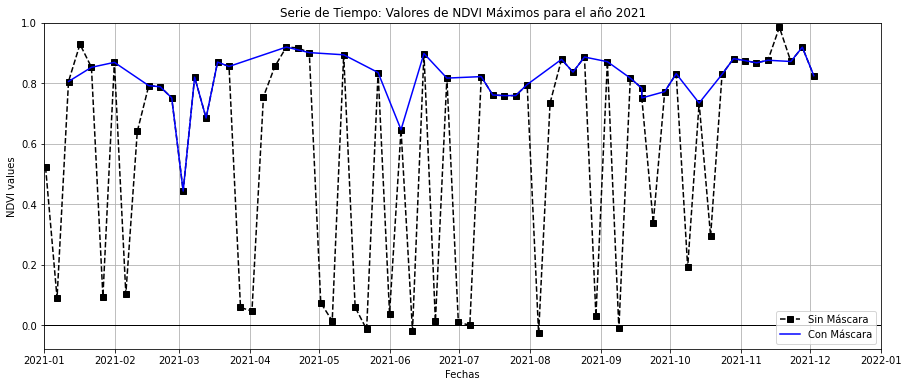

In [ ]:
# Visualización
plt.figure(figsize=(15,6))
plt.plot(df_sin_mask.Timestamp, df_sin_mask.NDVI, 'ks--', label='Sin Máscara')
plt.plot(df_con_mask.Timestamp, df_con_mask.NDVI, 'b-', label='Con Máscara')

# plt.plot(dfs2['Fecha Precisa'], dfs2['Porcentaje Nubes (%)']/100, 'cs-') # Nubosidad en imágenes
plt.title(f'Serie de Tiempo: Valores de NDVI Máximos para el año {year}'), plt.xlabel('Fechas'), plt.ylabel('NDVI values')
plt.xlim(pd.Timestamp('2021'),pd.Timestamp('2022'))
plt.xticks([pd.Timestamp(f'2021-{i}') for i in range(1,13)]+[pd.Timestamp('2022-1')])
plt.gca().xaxis.set_major_formatter(date_format)
plt.ylim(top=1)
plt.legend(loc='lower right')
plt.axhline(0, color = 'black', linewidth = '1') # Resaltar el 0
plt.grid();

In [ ]:
# @markdown Visualización con Altair

base = alt.Chart(df_con_mask).encode(x=alt.X('Timestamp:T'))

points = base.mark_circle(size=60).encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Fecha'),
        alt.Tooltip('NDVI:Q', title='NDVI')
    ])

line = base.mark_line().encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma'))
)

(points+line).properties(width=800, height=400).interactive()

alt.LayerChart(...)

In [ ]:
df_ag_dic =  s2_parcelas_df.copy()

##### Landsat 8

###### 1. Filtrado de `ee.ImageCollection`

In [ ]:
snippet_name = 'LANDSAT/LC08/C02/T1_L2'
year = 2021
roi = ee.Geometry.Point([-79.39762925890398, -6.612494380904333])
path = 10
row = 65

# lista_bandas = ['B2','B3','B4','B8'] # ['B4','B8']

parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape").geometry() # Abarca 1139 puntos en una imagen sentinel-2

## Filtrado de ee.imageCollection
s2 = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
    .map(get_ndvi_L8)
    .select("NDVI")
)

###### 2. Reducciones por región

- Javier Quille comenta:
  > Sentinel-2 SR al presentar calibración atmosférica y radiométrica brinda información procesada, por ello **se toma los valores máximos de NDVI** ya que las nubes tienden a bajar el mismo.

In [ ]:
reduce_parcelas_chongoyape = create_reduce_region_function(geometry=parcelas_chongoyape, reducer=ee.Reducer.max(), scale=30)

reduce_s2 = (
    ee.FeatureCollection(s2.map(reduce_parcelas_chongoyape))
    .filter(ee.Filter.notNull(s2.first().bandNames()))
)

s2_parcelas_dict = fc_to_dict(reduce_s2).getInfo()

print(type(s2_parcelas_dict), '\n')
for prop in s2_parcelas_dict.keys():
    print(prop + ':', s2_parcelas_dict[prop][0:3] + ['...'])

<class 'dict'> 

NDVI: [0.8037763294078156, 0.7501544732192218, 0.743957541418633, '...']
millis: [1609601314101, 1612366105244, 1615130893534, '...']
system:index: ['LC08_010065_20210102', 'LC08_010065_20210203', 'LC08_010065_20210307', '...']


In [ ]:
s2_parcelas_df = pd.DataFrame(s2_parcelas_dict)[['millis','system:index', 'NDVI']]

s2_parcelas_df = add_date_info(s2_parcelas_df)
s2_parcelas_df = s2_parcelas_df.drop(columns=['millis', 'system:index'])
s2_parcelas_df

NDVI               Timestamp  Year  Month  Day  DOY
0   0.803776 2021-01-02 15:28:34.101  2021      1    2    2
1   0.750154 2021-02-03 15:28:25.244  2021      2    3   34
2   0.743958 2021-03-07 15:28:13.534  2021      3    7   66
3   0.837388 2021-03-23 15:28:06.322  2021      3   23   82
4   0.012083 2021-04-08 15:28:01.927  2021      4    8   98
5   0.910918 2021-04-24 15:27:54.495  2021      4   24  114
6   0.841911 2021-05-10 15:27:49.775  2021      5   10  130
7   0.849862 2021-05-26 15:27:59.826  2021      5   26  146
8   0.904950 2021-06-11 15:28:06.858  2021      6   11  162
9   0.800255 2021-06-27 15:28:11.059  2021      6   27  178
10  0.764483 2021-07-13 15:28:12.418  2021      7   13  194
11  0.001464 2021-07-29 15:28:20.132  2021      7   29  210
12  0.787934 2021-08-14 15:28:26.458  2021      8   14  226
13  0.746338 2021-08-30 15:28:31.022  2021      8   30  242
14  0.707852 2021-09-15 15:28:34.999  2021      9   15  258
15  0.765711 2021-10-01 15:28:39.556  2021     10    1  274
16  0.811143 2021-10-17 15:28:43.526  2021     10   17  290
17  0.820429 2021-11-02 15:28:43.159  2021     11    2  306
18  0.826813 2021-11-18 15:28:37.613  2021     11   18  322

###### 3. Visualización

In [ ]:
# DataFrames NDVI: Correr dos veces para registrar ambos valores comentando uno y descomentando el otro
# df_con_mask = s2_parcelas_df.copy()
# df_sin_mask = s2_parcelas_df.copy()

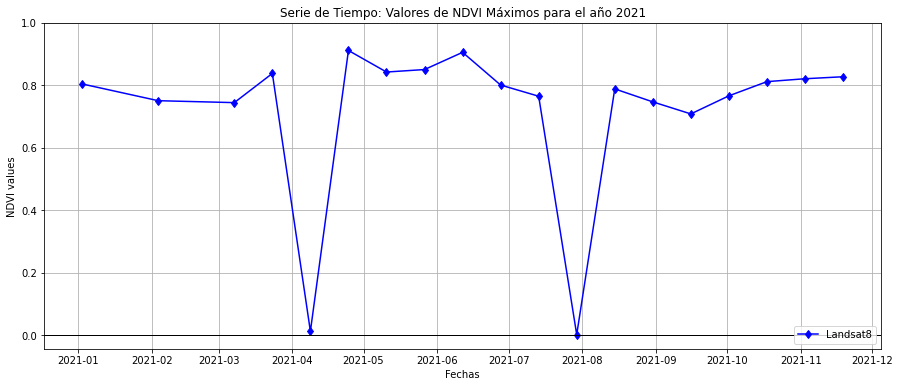

In [ ]:
# Visualización
plt.figure(figsize=(15,6))

# plt.plot(df_sin_mask.Timestamp, df_sin_mask.NDVI, 'ks--', label='Sin Máscara')
# plt.plot(df_con_mask.Timestamp, df_con_mask.NDVI, 'b-', label='Con Máscara')

plt.plot(s2_parcelas_df.Timestamp, s2_parcelas_df.NDVI, 'bd-', label='Landsat8')

# plt.plot(dfs2['Fecha Precisa'], dfs2['Porcentaje Nubes (%)']/100, 'cs-') # Nubosidad en imágenes
plt.title(f'Serie de Tiempo: Valores de NDVI Máximos para el año {year}'), plt.xlabel('Fechas'), plt.ylabel('NDVI values')
# plt.xlim(pd.Timestamp('2021'),pd.Timestamp('2022'))
# plt.xticks([pd.Timestamp(f'2021-{i}') for i in range(1,13)]+[pd.Timestamp('2022-1')])
# plt.gca().xaxis.set_major_formatter(date_format)
plt.ylim(top=1)
plt.legend(loc='lower right')
plt.axhline(0, color = 'black', linewidth = '1') # Resaltar el 0
plt.grid();

In [ ]:
# @markdown Visualización con Altair

base = alt.Chart(s2_parcelas_df).encode(x=alt.X('Timestamp:T'))

points = base.mark_circle(size=60).encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Fecha'),
        alt.Tooltip('NDVI:Q', title='NDVI')
    ])

line = base.mark_line().encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma'))
)

(points+line).properties(width=800, height=400).interactive()

alt.LayerChart(...)

##### Landsat 7

###### 1. Filtrado de `ee.ImageCollection`

In [ ]:
snippet_name = 'LANDSAT/LE07/C02/T1_L2'
year = 2021
roi = ee.Geometry.Point([-79.39762925890398, -6.612494380904333])
path = 10
row = 65

# lista_bandas = ['B2','B3','B4','B8'] # ['B4','B8']

parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape").geometry() # Abarca 1139 puntos en una imagen sentinel-2

## Filtrado de ee.imageCollection
s2 = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
    .map(get_ndvi_L7)
    .select("NDVI")
)

###### 2. Reducciones por región

- Javier Quille comenta:
  > Sentinel-2 SR al presentar calibración atmosférica y radiométrica brinda información procesada, por ello **se toma los valores máximos de NDVI** ya que las nubes tienden a bajar el mismo.

In [ ]:
reduce_parcelas_chongoyape = create_reduce_region_function(geometry=parcelas_chongoyape, reducer=ee.Reducer.max(), scale=30)

reduce_s2 = (
    ee.FeatureCollection(s2.map(reduce_parcelas_chongoyape))
    .filter(ee.Filter.notNull(s2.first().bandNames()))
)

s2_parcelas_dict = fc_to_dict(reduce_s2).getInfo()

print(type(s2_parcelas_dict), '\n')
for prop in s2_parcelas_dict.keys():
    print(prop + ':', s2_parcelas_dict[prop][0:3] + ['...'])

<class 'dict'> 

NDVI: [0.7812201162977175, 0.7587560765939905, 0.4432792186219575, '...']
millis: [1610289967022, 1611672298351, 1613054627397, '...']
system:index: ['LE07_010065_20210110', 'LE07_010065_20210126', 'LE07_010065_20210211', '...']


In [ ]:
s2_parcelas_df = pd.DataFrame(s2_parcelas_dict)[['millis','system:index', 'NDVI']]

s2_parcelas_df = add_date_info(s2_parcelas_df)
s2_parcelas_df = s2_parcelas_df.drop(columns=['millis', 'system:index'])
s2_parcelas_df

NDVI               Timestamp  Year  Month  Day  DOY
0   0.781220 2021-01-10 14:46:07.022  2021      1   10   10
1   0.758756 2021-01-26 14:44:58.351  2021      1   26   26
2   0.443279 2021-02-11 14:43:47.397  2021      2   11   42
3   0.473177 2021-02-27 14:42:34.377  2021      2   27   58
4   0.156802 2021-03-15 14:41:19.021  2021      3   15   74
5   0.063720 2021-03-31 14:40:01.364  2021      3   31   90
6   0.424990 2021-04-16 14:38:41.509  2021      4   16  106
7   0.879678 2021-05-02 14:37:20.446  2021      5    2  122
8   0.034748 2021-06-03 14:34:37.894  2021      6    3  154
9   0.686954 2021-06-19 14:33:19.918  2021      6   19  170
10  0.001505 2021-07-05 14:31:59.797  2021      7    5  186
11  0.145808 2021-07-21 14:30:37.638  2021      7   21  202
12  0.678425 2021-08-06 14:29:13.380  2021      8    6  218
13  0.487419 2021-08-22 14:27:48.788  2021      8   22  234
14  0.014378 2021-09-07 14:26:25.718  2021      9    7  250
15  0.306903 2021-10-09 14:23:35.420  2021     10    9  282
16  0.670219 2021-10-25 14:22:08.943  2021     10   25  298
17  0.448533 2021-11-10 14:20:38.376  2021     11   10  314

###### 3. Visualización

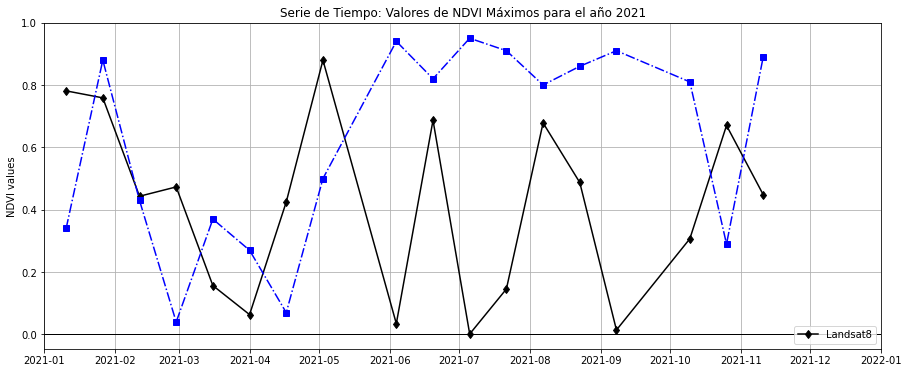

In [ ]:
# Visualización
plt.figure(figsize=(15,6))

plt.plot(s2_parcelas_df.Timestamp, s2_parcelas_df.NDVI, 'kd-', label='Landsat8')
plt.plot(reporteL7_C2['Fecha Precisa'], reporteL7_C2['CLOUD_COVER']/100, 'bs-.') # Nubosidad en imágenes
plt.title(f'Serie de Tiempo: Valores de NDVI Máximos para el año {year}'), plt.ylabel('NDVI values'), plt.ylim(top=1)

plt.xlim(pd.Timestamp('2021'),pd.Timestamp('2022'))
plt.xticks([pd.Timestamp(f'2021-{i}') for i in range(1,13)]+[pd.Timestamp('2022-1')])
plt.gca().xaxis.set_major_formatter(date_format)

plt.legend(loc='lower right')
plt.axhline(0, color = 'black', linewidth = '1') # Resaltar el 0
plt.grid();

In [ ]:
# @markdown Visualización con Altair

base = alt.Chart(s2_parcelas_df).encode(x=alt.X('Timestamp:T'))

points = base.mark_circle(size=60).encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Fecha'),
        alt.Tooltip('NDVI:Q', title='NDVI')
    ])

line = base.mark_line().encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma'))
)

(points+line).properties(width=800, height=400).interactive()

alt.LayerChart(...)

## Balance de Energía Superficial - Modelo METRIC

- METRIC (2007) se realizó con imágenes Landsat 7 ETM+ y Landsat 8 empezó a operar en 2013.

Se ha seguido la metodología empleada en la siguiente investigación:
> Allen, R. G., Tasumi, M., & Trezza, R. (2007). Satellite-based energy balance for mapping evapotranspiration with internalized calibration (METRIC)—Model. Journal of irrigation and drainage engineering, 133(4), 380-394. doi:[10.1061/(ASCE)0733-9437(2007)133:4(380)](http://cursosihlla.bdh.org.ar/ET_UNCu_Cursos/Curso_2019/1_Lectura_recomendada/2007_Allen_METRIC_Satellite-Based_Energy_Balance_for_Mapping_Evapotr.pdf) 

**Ecuación del Balance de energía**

$$
LE = R_n - G - H
$$

Dónde: 
- $LE$ : Energía latente consumida por ET $[W/m²]$
- $R_n$ : Radiación neta (suma de todas las radiaciones de onda corta y larga, sean entrantes o salientes a la superficie) $[W/m²]$
- $G$ : Flujo de calor sensible conducido al suelo $[W/m²]$
- $H$ : Flujo de calor sensible convectado al aire $[W/m²]$

### Radiación Neta / Net Radiation $R_n$

Morse et al. 2000:

$$
R_n = (1- \alpha)R_{S\downarrow} + (R_{L\downarrow} - R_{L\uparrow}) - (1- \epsilon_0)R_{L\downarrow}
$$

Dónde: 
- $R_n$ : Flujo de radiación neta $[W/m^2]$
- $\alpha$ : Albedo de superficie
- $R_{S\downarrow}$ : Radiación de onda corta entrante $[W/m^2]$
- $R_{L\downarrow}$ : Radiación de onda larga entrante $[W/m^2]$
- $R_{L\uparrow}$ : Radiación de onda larga saliente $[W/m^2]$
- $\epsilon_0$ : Emisividad del ancho de banda en la superficie / broad-band surface thermal emissivity

The $(1- \epsilon_0)R_{L\downarrow}$ term represents the fraction of incoming long-wave
radiation reflected from the surface.

#### Albedo / Surface Albedo $\alpha_{s}$

In [52]:
# @markdown Función: `get_albedo(image)`

def get_albedo(image):
  """
  Obtener el albedo de una imagen mediante una calibración con 
  coeficientes de ponderación por banda (Da Silva et al., 2016)
  https://www.scielo.br/j/rbeaa/a/sX6cJjNXWMfHQ5p4h33B8Zz/?lang=en

  Argumentos:
      image (ee.Image) : Imagen satelital de Earth Engine.

  Retorna: 
      albedo (ee.Image) : Albedo de una imagen satelital. 
      
  """

  # Obtener nombres de las bandas de la imagen
  bandnames = image.bandNames().getInfo()[1:7]

  # Expresión para obtener el albedo
  albedo = image.expression(
      '(0.3*B2 + 0.277*B3 + 0.233*B4 + 0.143*B5 + 0.036*B6 + 0.012*B7)',
      {
          'B2' : image.select(bandnames[0]),
          'B3' : image.select(bandnames[1]),
          'B4' : image.select(bandnames[2]),
          'B5' : image.select(bandnames[3]),
          'B6' : image.select(bandnames[4]),
          'B7' : image.select(bandnames[5])
      }
  ).rename('albedo')

  return image.addBands(albedo)

In [53]:
img_id = 'LANDSAT/LE07/C02/T1_L2/LE07_010065_20210502' # Landsat 7

In [54]:
# @markdown Comparación entre L8_L2 y L8_SR: Albedo

roi = chongoyape

img_C1 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_010065_20200116').multiply(0.0001) 
img_C1_viz = {'min':0, 'max':0.3, 'gamma':1.4, 'bands':['B4','B3','B2']}
img_C1_albedo = get_albedo(img_C1)#.clip(roi)

img_C2 = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_010065_20200116').multiply(0.0000275).add(-0.2)
img_C2_viz = {'min':0, 'max':0.3, 'gamma':1.4, 'bands':['SR_B4','SR_B3','SR_B2']}
img_C2_albedo = get_albedo(img_C2)#.clip(roi)

viz_params = {'min': 0.0, 'max':0.3, 'palette': yuri_ndvi_pal};

# Visualización
Map = geemap.Map()#basemap='OpenStreetMap.Mapnik', layer_ctrl=True)
Map.centerObject(roi, 11) # Map.setCenter(lon, lat, zoom)
Map.addLayer(img_C1, img_C1_viz, 'L8 C1 Imagen')
Map.addLayer(img_C1_albedo.select('albedo'), viz_params, 'L8 C1 Albedo')
Map.addLayer(img_C2, img_C2_viz, 'L8 C2 Imagen')
Map.addLayer(img_C2_albedo.select('albedo'), viz_params, 'L8 C2 Albedo')
Map

Map(center=[-6.626857361870171, -79.46457297581195], controls=(WidgetControl(options=['position', 'transparent…

#### Radiación de onda corta entrante / Incoming Solar Radiation $R_{S\downarrow}$ 

<img src='https://www.aulafacil.com/uploads/cursos/5922/20208_angulos-y-altura-en-la-trayectoria-del-sol.es.jpg' width='50%'/>

#### Radiación de onda larga saliente / Outgoing Long-Wave Radiation $R_{L\uparrow}$ 

#### Radiación de onda larga entrante / Incoming Long-Wave Radiation $R_{L\downarrow}$

### Flujo de calor del suelo / Soil Heat Flux $G$

### Flujo de calor sensible / Sensible Heat Flux $H$

### $\lambda{ET}$ y $ET$ instantánea

### Evapotranspiración de cultivo $ET_c$ por día